In [1]:
import numpy as np
import pyproj
import matplotlib.pyplot as plt
import geopandas as gpd
import shapely 

/usr/local/lib/python3.6/dist-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#### Intersect points with a regular grid without a spatial index
- Intersecing points with a regular grid on a cartesian plane can be done efficiently using only NumPy and vectorized operations, without relying on spatial indexes or brute force approaches.

In [2]:
def create_grid(xmin, ymin, xmax, ymax, xstep, ystep):
    """
    Create bounding coordinates for a regular 2d grid with numpy.
    These coordinates can then be used with shapely, pygeos and geopandas.
    """
    
    # Generate two evenly spaced ranges
    x = np.linspace(xmin, xmax, int(xstep+1))
    y = np.linspace(ymin, ymax, int(ystep+1))
    
    # Get center points for each range
    x = np.mean((x[1:], x[:-1]), axis=0)
    y = np.mean((y[1:], y[:-1]), axis=0)
    
    # Cartesian product of both ranges 
    x, y = np.meshgrid(x, y)
    x, y = x.ravel(), y.ravel()

    # Calculate delta x and delta y
    xd = (xmax - xmin) / (xstep * 2)
    yd = (ymax - ymin) / (ystep * 2)
    
    # Repeat center points and add respective delta
    grid = np.column_stack((x,y))
    grid = np.tile(grid, 2) + np.array([[-xd, -yd, xd, yd]])
    
    # Generate index
    grid_index = np.arange(0, xstep * ystep)
    
    # Output coordinates: xmin, ymin, xmax, ymax
    return grid, grid_index

def intersect_points_grid(xy, xmin, ymin, xmax, ymax, xstep, ystep, open_x=False, open_y=True):
    """
    Intersect 2d Points with a regular 2d Grid using NumPy.
    Returns the index of the Grid rectangle that each Point belongs to.
    """
    
    # Calculate delta x and delta y
    xd = (xmax - xmin) / xstep
    yd = (ymax - ymin) / ystep
    
    # Center points at zero
    xy = xy - np.array([[xmin, ymin]])
    
    # Get index of x and y coordinates
    xi = np.floor(xy[:,0] / xd) 
    yi = np.floor(xy[:,1] / yd) 
    
    # Opened interval for x
    if open_x == True:
        xi = xi - (xy[:,0] % xd == 0)
    
    # Opened interval for y
    if open_y == True:
        yi = yi - (xy[:,1] % yd == 0)
    
    # Cast to intenger
    xi = xi.astype(np.int64)
    yi = yi.astype(np.int64) 
    
    # Calculate index
    index = xi + (yi * xstep)

    return index 


##### Create example grid

In [3]:
grid, grid_index = create_grid(xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5)

##### Create example points

In [4]:
test_points = np.array([[10, 50],
                        [10, 60],
                        [20, 50],
                        [20, 60],
                        [11, 51],
                        [14, 54],
                        [11.5, 57.7],
                        [17.5, 54.5]])

##### Plot grid and Points

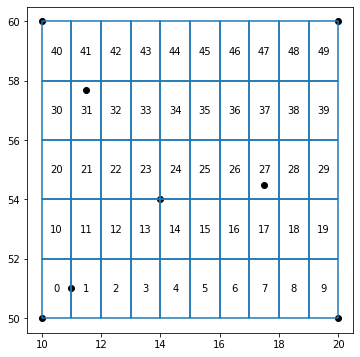

In [5]:
grid_shapely = list(map(lambda x: shapely.geometry.box(*x), grid))

fig, ax = plt.subplots(figsize=(6,6))

gpd.GeoDataFrame(geometry=grid_shapely).exterior.plot(ax=ax)

for coos, index in zip(grid, grid_index):
    ax.text(coos[[0,2]].mean(), coos[[1,3]].mean(), str(index), horizontalalignment='center', verticalalignment='center')
    
ax.scatter(test_points[:,0], test_points[:,1], color='black')

##### Intersect Points with Grid
- The parameters that define the grid must be known.
- Depending if the intervals are closed or opened on the x and y axis, the index returned will change for points that lie exactly on top of grid bounds.
- For the other points that lie inside the rectangles the index will remain the same.
- For example, assuming the point x=14, y=54:
    - If both intervals are closed its index will be 24. 
    - If the x interval is opened it will lie on rectangle 23.
    - If the y interval is opened it will lie on rectangle 14.
    - If both intervals are opened its index will be 13.

In [6]:
intersect_points_grid(xy=test_points, xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5, open_x=False, open_y=False)

array([ 0, 50, 10, 60,  1, 24, 31, 27])

In [7]:
intersect_points_grid(xy=test_points, xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5, open_x=True, open_y=False)

array([-1, 49,  9, 59,  0, 23, 31, 27])

In [8]:
intersect_points_grid(xy=test_points, xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5, open_x=False, open_y=True)

array([-10,  40,   0,  50,   1,  14,  31,  27])

In [9]:
intersect_points_grid(xy=test_points, xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5, open_x=True, open_y=True)

array([-11,  39,  -1,  49,   0,  13,  31,  27])

##### Next steps
- Now it's possible to use NumPy indexing or a database join (Pandas, Dask or Pyspark), to merge 2d Points with their respective rectangle on a predefined regular grid.

In [10]:
index = intersect_points_grid(xy=test_points, xmin=10, ymin=50, xmax=20, ymax=60, xstep=10, ystep=5, open_x=False, open_y=False)

In [11]:
# Filter points that are inside bounds of array
iob = (index >= 0) & (index < grid_index.shape[0])

In [12]:
test_points[iob]

array([[10. , 50. ],
       [20. , 50. ],
       [11. , 51. ],
       [14. , 54. ],
       [11.5, 57.7],
       [17.5, 54.5]])

In [13]:
grid[index[iob]]

array([[10., 50., 11., 52.],
       [10., 52., 11., 54.],
       [11., 50., 12., 52.],
       [14., 54., 15., 56.],
       [11., 56., 12., 58.],
       [17., 54., 18., 56.]])